In [171]:
import sys
sys.path.append('./../Quality/')
from Quality import compute_overlap_array

import pickle
import itertools
import numpy as np
from skimage.measure import label
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage.filters import convolve
from scipy.spatial.distance import euclidean as l2_dist

In [2]:
cutouts = pickle.load(open('downsample_mean_collman15.pkl', 'rb'))

In [27]:
def compute_pairwise_vol_cov(vol1, vol2, local_shape):
    e1 = pool(vol1, local_shape, np.mean)
    e2 = pool(vol2, local_shape, np.mean)
    
    s1 = pool(vol1, local_shape, np.std)
    s2 = pool(vol2, local_shape, np.std)
    
    e12 = pool(np.log(np.exp(vol1)+np.exp(vol2)), local_shape, np.mean)
    
    cov = e12 - np.log(np.exp(e1) + np.exp(e2))
    
    return cov

In [6]:
print(cutouts.keys())

dict_keys(['PSD95_488', 'gephyrin594', 'annotation', 'GAD647', 'NR1594', 'GS594', 'Synapsin647', 'GABA488', 'VGluT1_647', 'MBP488'])


In [28]:
def z_transform(img):
    sigma = np.std(img)
    mu = np.average(img)
    return (img - mu)/sigma

In [184]:
input_chans = {}
for key, val in cutouts.items():
    if not 'annot' in key:
        input_chans[key] = val

In [ ]:
def get_prepicked_pairwise_model(chans, selem):
    
    pair_list = [['gephyrin594', 'GAD647'],
                ['gephyrin594', 'NR1594'],
                ['PSD95_488', 'NR1594'],
                ['gephyrin594', 'Synapsin647'],
                ['PSD95_488', 'Synapsin647'],
                ['GABA488', 'VGluT1_647'],
                ['NR1594', 'VGluT1_647'],
                ['Synapsin647', 'VGluT1_647']]
    
    conved_chans = {}
    for chan_name in np.array(pair_list).flatten():
        if not chan_name in conved_chans.keys():
            conved_chans[chan_name] = convolve(np.stack(chans[chan_name]), selem)
    
    model_set = []
    for a_chan, b_chan in pair_list:
      
        flat_a = [np.log(elem) for elem in np.array(conved_chans[a_chan]).flatten() if not elem == 0]
        flat_b = [np.log(elem) for elem in np.array(conved_chans[b_chan]).flatten() if not elem == 0]
        
        my_input = np.array([*(zip(flat_a, flat_b))])
        model_set.append(KMeans(n_clusters=2).fit(my_input).cluster_centers_)
       
    return pair_list, model_set

In [205]:
def make_model_scatter(cutouts, a_name, b_name, model, selem):
    
    annot = cutouts['annotation']
    conv_chans = {a_name: convolve(cutouts[a_name], selem),
                  b_name: convolve(cutouts[b_name], selem)}

    flat_a = np.array(conv_chans[a_name]).flatten()
    flat_b = np.array(conv_chans[b_name]).flatten()
    flat_annot = np.array(annot).flatten()
    
    log_a = [np.log(elem) for elem in flat_a if elem]
    log_b = [np.log(elem) for elem in flat_b if elem]
    conjugate = [elem for i, elem in enumerate(flat_annot) if flat_a[i] * flat_b[i]]
    
    true_iset = np.where(np.array(conjugate) > 0)[0]
    true_isubset = [true_iset[int(i)] for i in np.linspace(0, len(true_iset)-1, 1000)]
    false_iset = np.where(np.array(conjugate) == 0)[0]
    false_isubset = [false_iset[int(i)] for i in np.linspace(0, len(false_iset)-1, 1000)]
    
    plt.figure()
    plt.title(a_name + ', ' + b_name)
    print(a_name, ' ', b_name)
    plt.subplot(121)
    for i in true_isubset:
        if l2_dist([log_a[i], log_b[i]], model[0]) < l2_dist([log_a[i], log_b[i]], model[1]) :
            plt.scatter(log_a[i], log_b[i], c='b')
        else:
            plt.scatter(log_a[i], log_b[i], c='y')
            
    for i in false_isubset:
        if l2_dist([log_a[i], log_b[i]], model[0]) < l2_dist([log_a[i], log_b[i]], model[1]) :
            plt.scatter(log_a[i], log_b[i], c='b')
        else:
            plt.scatter(log_a[i], log_b[i], c='y')
           

    plt.subplot(122)
    for i in true_isubset:
            plt.scatter(log_a[i], log_b[i], c='g')
            
    for i in false_isubset:
            plt.scatter(log_a[i], log_b[i], c='r')
            
    plt.show()

In [206]:
pair_list, model_set = get_prepicked_pairwise_model(input_chans, selem = np.ones((9, 11, 11)))

gephyrin594   GAD647


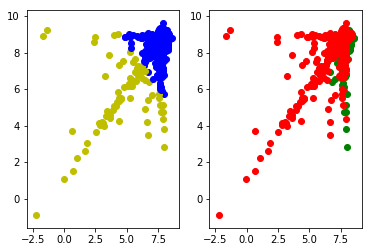

gephyrin594   NR1594


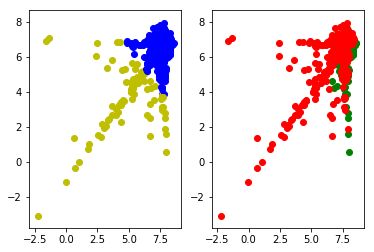

PSD95_488   NR1594


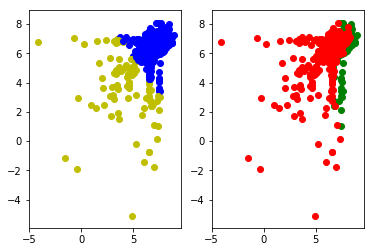

gephyrin594   Synapsin647


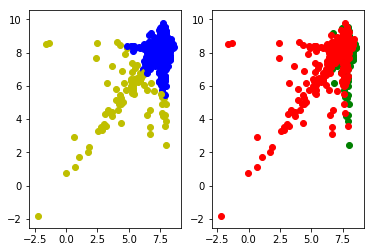

PSD95_488   Synapsin647


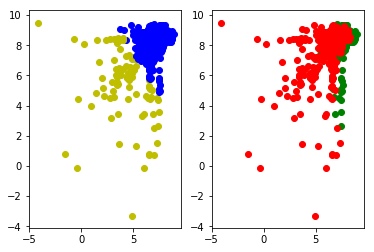

GABA488   VGluT1_647


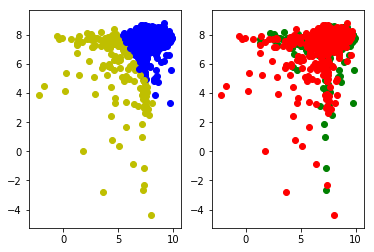

NR1594   VGluT1_647


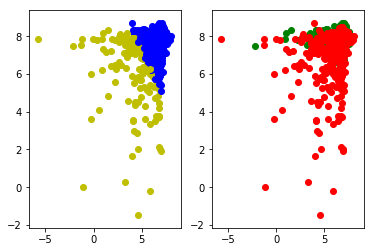

Synapsin647   VGluT1_647


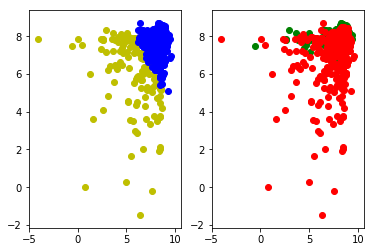

In [207]:
for i in range(len(pair_list)):
    make_model_scatter(cutouts,
                       pair_list[i][0],
                       pair_list[i][1],
                       model_set[i],
                       np.ones((3, 10, 10)))